In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import shutil,time,os
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
from tqdm import tqdm
# NLP
import string, re, nltk
from string import punctuation
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
# !pip install num2words
from num2words import num2words
# !pip install pyspellchecker
# from spellchecker import SpellChecker
from nltk.stem.porter import PorterStemmer
import spacy
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer

# Scipy
import scipy
from scipy import sparse
from scipy.sparse import csr_matrix

# Train-test split and cross validation
from sklearn.model_selection import train_test_split, ParameterGrid

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

# Model evaluation
from sklearn import metrics
from sklearn.metrics import accuracy_score

# Others
import json
import gensim
from sklearn.decomposition import TruncatedSVD

# Load Data

In [2]:
input_data=pd.read_csv("./ecommerceDataset.csv",names=["Label","describtion"])
input_data.head(2)

,Label,describtion
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."


In [3]:
input_data.isna().sum()

Label          0
describtion    1
dtype: int64

In [4]:
input_data.shape

(50425, 2)

In [5]:
input_data.dropna(inplace=True)

In [6]:
input_data.isna().sum()

Label          0
describtion    0
dtype: int64

In [7]:
input_data.shape

(50424, 2)

# Remove Duplicate

In [8]:
input_data.drop_duplicates(subset="describtion",inplace=True)

In [9]:
input_data.shape

(27802, 2)

# Prepare Data For Word Embedding Model Training 

In [10]:
input_data.head(5)

,Label,describtion
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...


In [16]:
from nltk import sent_tokenize
from gensim.utils import simple_preprocess
full_word_data=[]
for s_row_data in tqdm(input_data.iterrows()):
    desc_data=s_row_data[1][1]
    raw_sentence=sent_tokenize(desc_data)
    for single_sentence in raw_sentence:
        full_word_data.append(simple_preprocess(single_sentence))

27802it [00:10, 2644.32it/s]


In [23]:
import gensim
model = gensim.models.Word2Vec(
    window=10,
    min_count=2,
    workers=4,
    vector_size=300
)

In [24]:
model.build_vocab(full_word_data)

In [28]:
model.train(full_word_data,total_examples=model.corpus_count,epochs=10)

(24830369, 29826140)

In [34]:
model.wv.most_similar("tv")

[('tuner', 0.7027583718299866),
 ('television', 0.6866086721420288),
 ('hdtv', 0.6770403981208801),
 ('dth', 0.6491666436195374),
 ('tvs', 0.6462986469268799),
 ('masterimage', 0.6414051651954651),
 ('crt', 0.6311691403388977),
 ('vcr', 0.6147069334983826),
 ('plasma', 0.6109355092048645),
 ('dvb', 0.6058114171028137)]

In [35]:
model.wv.get_normed_vectors().shape

(39394, 300)

# Target Column Encoding 

In [36]:
from sklearn.preprocessing import LabelEncoder
label_encode=LabelEncoder()
input_data["Label"]=label_encode.fit_transform(input_data["Label"])

In [37]:
input_data["Label"].value_counts()

Label
3    10564
0     6256
1     5674
2     5308
Name: count, dtype: int64

# Gensim Word2Vector

In [38]:
# import gensim.downloader as api
# word2vec_gen=api.load('word2vec-google-news-300')

In [39]:
# word2vec_gen.similarity(w1="great", w2="good")

# Pre-Processing 

In [41]:
input_data.head(5)

,Label,describtion
0,3,Paper Plane Design Framed Wall Hanging Motivat...
1,3,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,3,SAF 'UV Textured Modern Art Print Framed' Pain...
3,3,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,3,Incredible Gifts India Wooden Happy Birthday U...


In [48]:
nlp_pipeline=spacy.load("en_core_web_sm")
Final_input_lst=[]
for s_row in tqdm(input_data.iterrows()):
    temp_dict={}
    class_label=s_row[1][0]
    row_describtion=s_row[1][1]
    doc_text=nlp_pipeline(row_describtion)
    filtered_token=[s_word.lemma_ for s_word in doc_text if not s_word.is_punct and not s_word.is_stop]
    try:
        vectorized_text=model.wv.get_mean_vector(filtered_token)
        temp_dict["Label"]=class_label
        temp_dict["describtion"]=row_describtion
        temp_dict["vector"]=vectorized_text
        Final_input_lst.append(temp_dict)
        
    except:
        continue

27802it [10:36, 43.65it/s] 


In [49]:
Final_input_data=pd.DataFrame(Final_input_lst)
Final_input_data.head(5)

,Label,describtion,vector
0,3,Paper Plane Design Framed Wall Hanging Motivat...,"[-0.030394163, -0.0054216837, 0.0043782555, 0...."
1,3,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...","[-0.031301614, 0.0055817408, 0.009123811, -0.0..."
2,3,SAF 'UV Textured Modern Art Print Framed' Pain...,"[-0.0060423883, 0.0053699366, -0.021675682, 0...."
3,3,"SAF Flower Print Framed Painting (Synthetic, 1...","[-0.008459453, 0.0067127715, -0.018311227, 0.0..."
4,3,Incredible Gifts India Wooden Happy Birthday U...,"[-0.046191853, -0.020906098, -0.016201492, -0...."


In [50]:
Final_Final_input_data=Final_input_data.copy()

In [51]:
x,y=Final_Final_input_data.drop("Label",axis=1),Final_Final_input_data["Label"]
X_train,X_test,Y_train,Y_test=train_test_split(Final_Final_input_data.vector.values,
                                               Final_Final_input_data.Label,test_size=0.20,random_state=40,stratify=y)
X_val,X_test,Y_val,Y_test=train_test_split(X_test,Y_test,test_size=0.50,random_state=40,stratify=Y_test)

In [52]:
print("Shape of X_train before reshaping: ", X_train.shape)
print("Shape of X_test before reshaping: ", X_test.shape)
X_train_2d = np.stack(X_train)
X_train_2d=pd.DataFrame(X_train_2d.tolist())
X_test_2d =  np.stack(X_test)
X_test_2d=pd.DataFrame(X_test_2d.tolist())
print("Shape of X_train after reshaping: ", X_train_2d.shape)
print("Shape of X_test after reshaping: ", X_test_2d.shape)

Shape of X_train before reshaping:  (22240,)
Shape of X_test before reshaping:  (2781,)
Shape of X_train after reshaping:  (22240, 300)
Shape of X_test after reshaping:  (2781, 300)


# GradientBoostingClassifier

In [53]:
from sklearn.ensemble import GradientBoostingClassifier
clf=GradientBoostingClassifier()
clf.fit(X_train_2d,Y_train)

Y_prediction=clf.predict(X_test_2d)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
print(classification_report(Y_test,Y_prediction))
cm=confusion_matrix(Y_test,Y_prediction)
disp=ConfusionMatrixDisplay(cm)
disp.plot()

              precision    recall  f1-score   support

           0       0.95      0.91      0.93       626
           1       0.94      0.94      0.94       567
           2       0.92      0.89      0.90       531
           3       0.89      0.93      0.91      1057

    accuracy                           0.92      2781
   macro avg       0.93      0.92      0.92      2781
weighted avg       0.92      0.92      0.92      2781



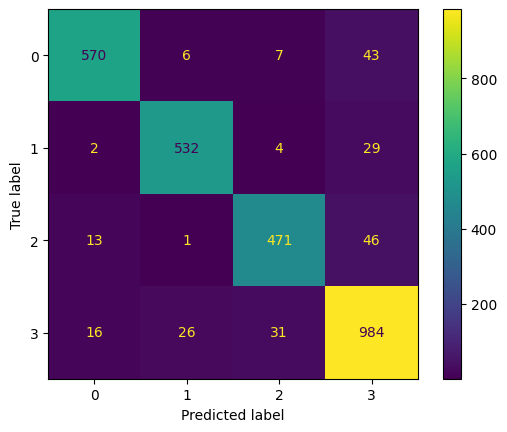

In [83]:
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
print(classification_report(Y_test,Y_prediction))
cm=confusion_matrix(Y_test,Y_prediction)
disp=ConfusionMatrixDisplay(cm)
disp.plot()

# DecisionTreeClassifier

              precision    recall  f1-score   support

           0       0.82      0.79      0.80       626
           1       0.78      0.80      0.79       567
           2       0.72      0.75      0.73       531
           3       0.78      0.78      0.78      1057

    accuracy                           0.78      2781
   macro avg       0.78      0.78      0.78      2781
weighted avg       0.78      0.78      0.78      2781



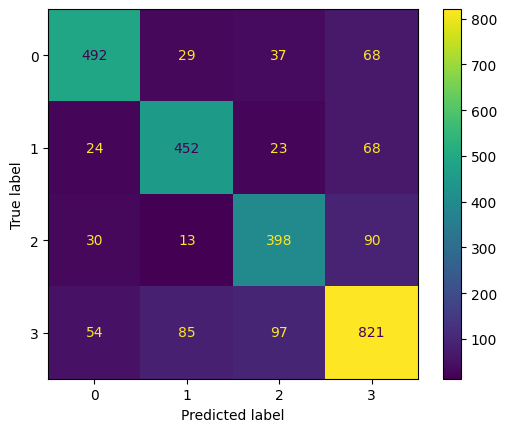

In [85]:
from sklearn.tree import DecisionTreeClassifier
dt_clf=DecisionTreeClassifier()
dt_clf.fit(X_train_2d,Y_train)

Y_prediction=dt_clf.predict(X_test_2d)
print(classification_report(Y_test,Y_prediction))
cm=confusion_matrix(Y_test,Y_prediction)
disp=ConfusionMatrixDisplay(cm)
disp.plot()

# Random Forest

              precision    recall  f1-score   support

           0       0.95      0.90      0.93       626
           1       0.96      0.94      0.95       567
           2       0.93      0.85      0.89       531
           3       0.88      0.95      0.91      1057

    accuracy                           0.92      2781
   macro avg       0.93      0.91      0.92      2781
weighted avg       0.92      0.92      0.92      2781



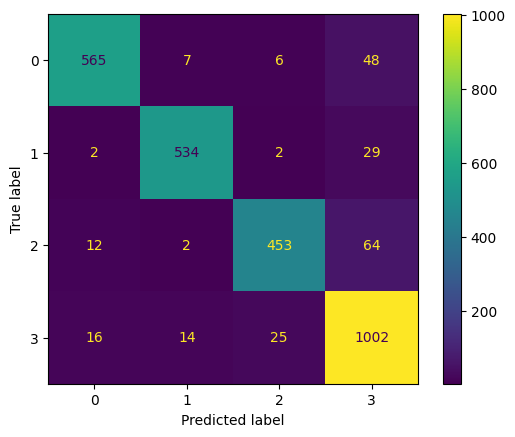

In [86]:
from sklearn.ensemble import RandomForestClassifier
dt_clf=RandomForestClassifier()
dt_clf.fit(X_train_2d,Y_train)

Y_prediction=dt_clf.predict(X_test_2d)
print(classification_report(Y_test,Y_prediction))
cm=confusion_matrix(Y_test,Y_prediction)
disp=ConfusionMatrixDisplay(cm)
disp.plot()